In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\jcuev\AppData\Local\Temp\ipykernel_10580\4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date

'2017-08-23'

<Figure size 1000x600 with 0 Axes>

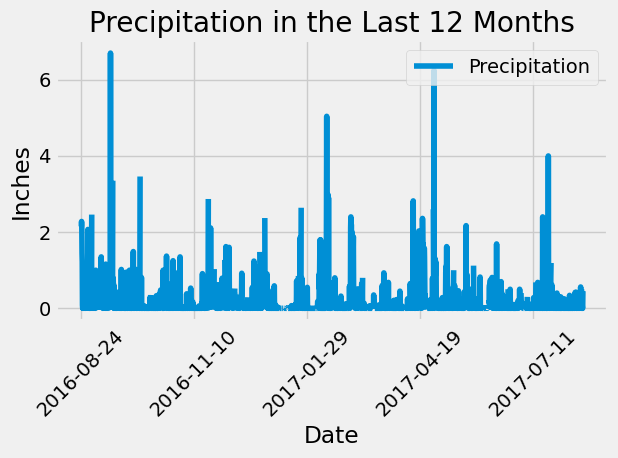

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')
# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]
query_result = session.query(*sel).filter(Measurement.date > one_year_ago).all()
# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(query_result, columns=['Date', 'Precipitation'])
df.set_index('Date', inplace=True)

# Sort the dataframe by date
df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
df.plot(title="Precipitation in the Last 12 Months", xlabel="Date", ylabel="Inches")
plt.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['Precipitation'].describe()
summary_statistics

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [11]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
total_stations

9

In [12]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(
    Measurement.station, 
    func.count(Measurement.station)
).group_by(Measurement.station
).order_by(func.count(Measurement.station).desc()
).all()
for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [13]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == 'USC00519281').all()
temperature_stats

[(54.0, 85.0, 71.66378066378067)]

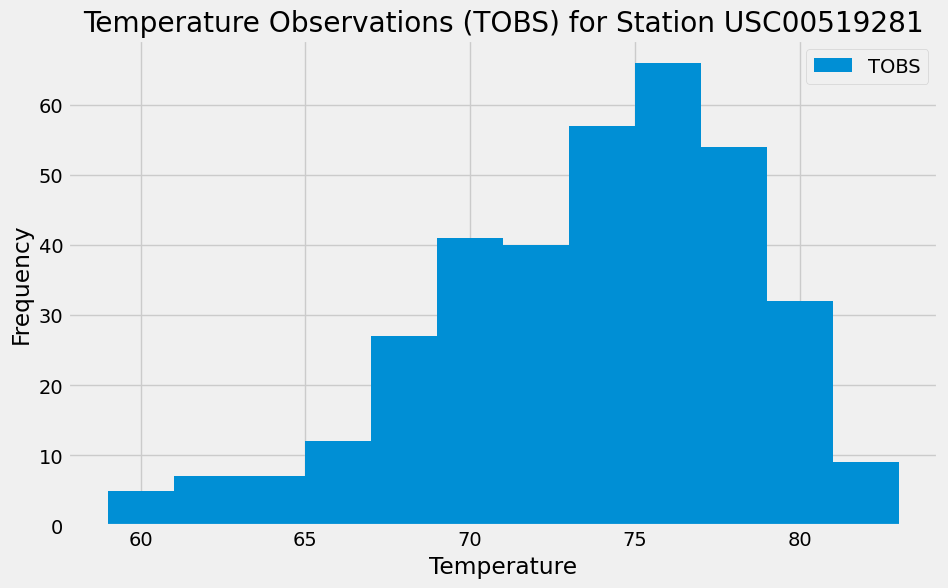

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_id = 'USC00519281'
last_date_str = session.query(func.max(Measurement.date)).filter(Measurement.station == station_id).scalar()
last_date = dt.datetime.strptime(last_date_str, '%Y-%m-%d')
start_date = last_date - dt.timedelta(days=365)
results = session.query(Measurement.tobs).\
    filter(Measurement.station == station_id).\
    filter(Measurement.date >= start_date.strftime('%Y-%m-%d')).\
    all()
temperatures = [temp[0] for temp in results]
plt.figure(figsize=(10, 6))
plt.hist(temperatures, bins=12, label='TOBS')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title(f'Temperature Observations (TOBS) for Station {station_id}')
plt.legend()
plt.show()

# Close Session

In [17]:
# Close Session
session.close()